# Customer Analysis and Engagement Prediction for ABC Company


## Objective

The goal of this project is to analyze customer data, identify patterns in engagement, and build a predictive model to forecast customer behavior. Insights from this analysis aim to inform strategies to boost engagement with ABC's digital product.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import shap

data = pd.read_csv('ecommerce_customer_data_large.csv')
import missingno as msno


sns.set(style="whitegrid")

#  Data Loading and Initial Exploration


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB
None
         Customer ID  Prod

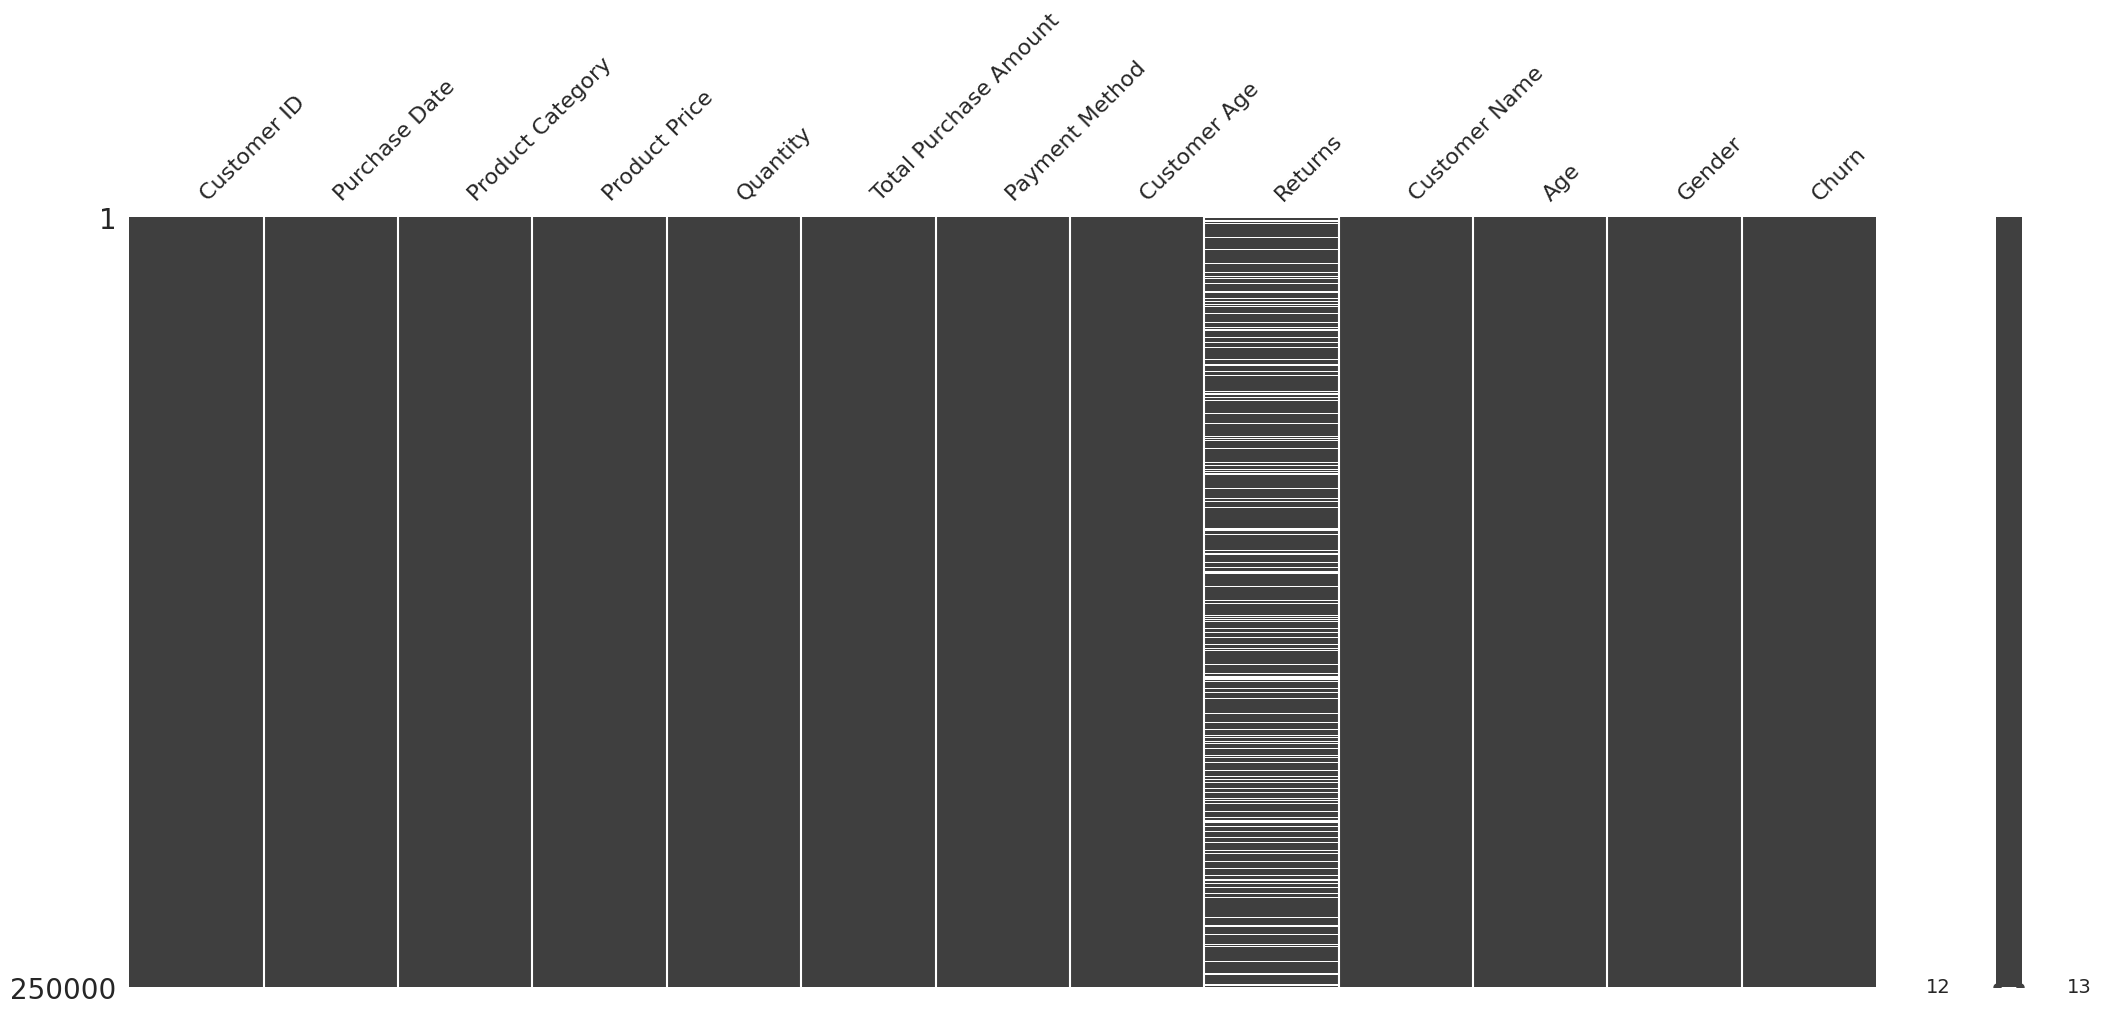

In [18]:

# Initial data overview
print(data.info())
print(data.describe())

# Missing values visualization
msno.matrix(data)
plt.show()



#  Data Cleaning

In [19]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [20]:
if data['Customer Age'].equals(data['Age']):
    print("The columns 'Customer Age' and 'Age' are identical. Dropping one of them.")
    data = data.drop(columns=['Age'])
else:
    print("The columns 'Customer Age' and 'Age' are not identical.")



The columns 'Customer Age' and 'Age' are identical. Dropping one of them.


In [21]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Gender                       0
Churn                        0
dtype: int64


Handle missing values in the 'Returns' column


In [22]:
#Fill missing 'Returns' values with 0 (assuming missing means no returns)
data['Returns'] = data['Returns'].fillna(0)


In [23]:
data.isnull().sum()


Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Gender                   0
Churn                    0
dtype: int64

Convert 'Purchase Date' to datetime format

In [24]:
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], errors='coerce')


Remove Irrelevant Columns


In [25]:
irrelevant_columns = ['Customer ID']  # Remove identifiers
data = data.drop(columns=irrelevant_columns, errors='ignore')

In [26]:
data['Year'] = data['Purchase Date'].dt.year
data['Month'] = data['Purchase Date'].dt.month
data['Day'] = data['Purchase Date'].dt.day
data['Day of Week'] = data['Purchase Date'].dt.dayofweek


Outlier Handling (Interquartile Range method)

In [28]:

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

print("\nCleaned data summary:\n")
print(data.describe())



Cleaned data summary:

                       Purchase Date  Product Price       Quantity  \
count                         250000  250000.000000  250000.000000   
mean   2021-11-06 19:26:22.286192384     254.742724       3.004936   
min              2020-01-01 00:07:26      10.000000       1.000000   
25%              2020-12-03 08:10:12     132.000000       2.000000   
50%       2021-11-06 07:39:08.500000     255.000000       3.000000   
75%    2022-10-11 01:21:56.249999872     377.000000       4.000000   
max              2023-09-13 18:42:49     500.000000       5.000000   
std                              NaN     141.738104       1.414737   

       Total Purchase Amount   Customer Age        Returns     Churn  \
count          250000.000000  250000.000000  250000.000000  250000.0   
mean             2725.385196      43.798276       0.405904       0.0   
min               100.000000      18.000000       0.000000       0.0   
25%              1476.000000      30.000000       0.00000

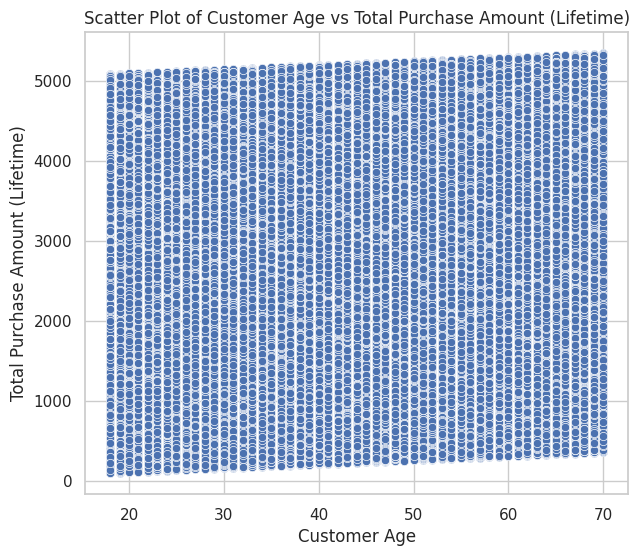

In [30]:
# Check if 'Total Purchase Amount' column exists to create a total purchase feature
if 'Total Purchase Amount' in data.columns:
    data['Total Purchase Amount_Lifetime'] = data['Total Purchase Amount']
else:
    print("Warning: 'Total Purchase Amount' column not found. Skipping total purchase calculation.")

# Check if 'Returns' exists to create a returns frequency feature
if 'Returns' in data.columns:
    data['Returns_Frequency'] = data['Returns']
else:
    print("Warning: 'Returns' column not found. Skipping returns frequency calculation.")

if 'Customer Age' in data.columns and 'Total Purchase Amount_Lifetime' in data.columns:
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=data['Customer Age'], y=data['Total Purchase Amount_Lifetime'])
    plt.title('Scatter Plot of Customer Age vs Total Purchase Amount (Lifetime)')
    plt.xlabel('Customer Age')
    plt.ylabel('Total Purchase Amount (Lifetime)')
    plt.show()
else:
    print("Skipping scatter plot: Required columns for plotting are not available.")


# Exploratory Data Analysis (EDA)

### Customer Segmentation by Product Category, Age, and Gender


- Distribution of purchases by product category

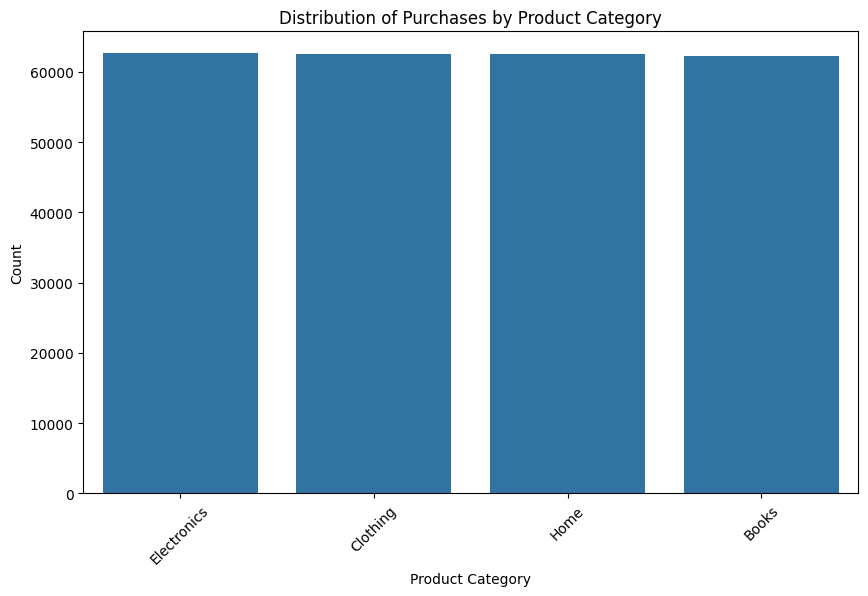

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Product Category', order=data['Product Category'].value_counts().index)
plt.title('Distribution of Purchases by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Age distribution of customers

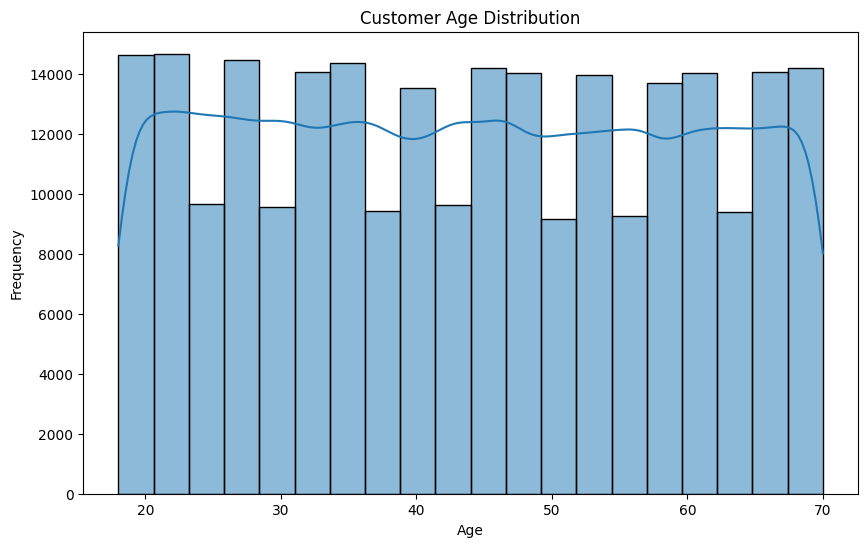

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Customer Age', bins=20, kde=True)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

- Gender distribution

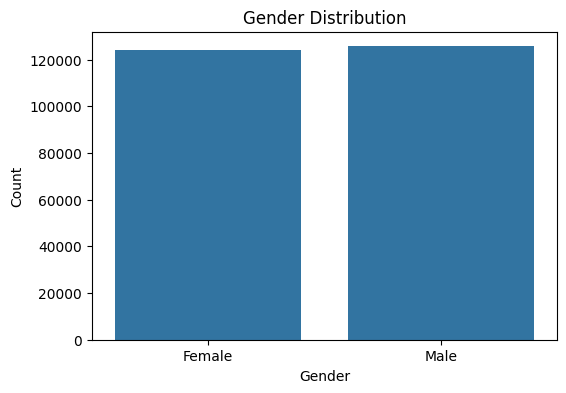

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Payment Preferences

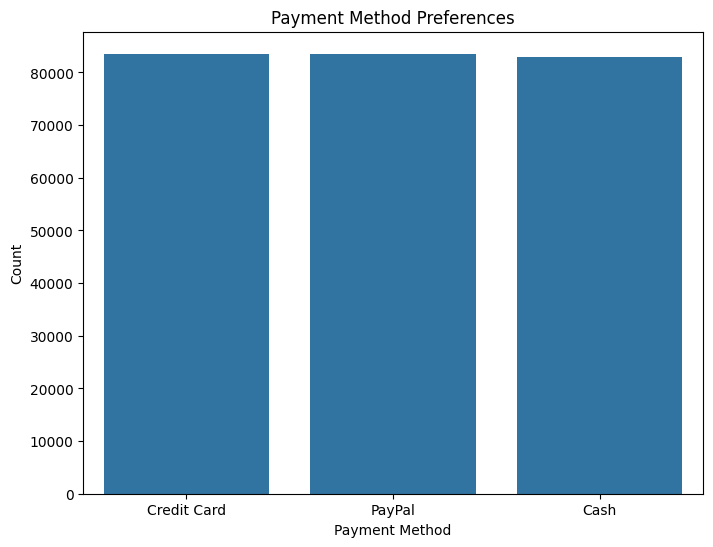

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Payment Method', order=data['Payment Method'].value_counts().index)
plt.title('Payment Method Preferences')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

### Churn Analysis

-  Distribution of Churn

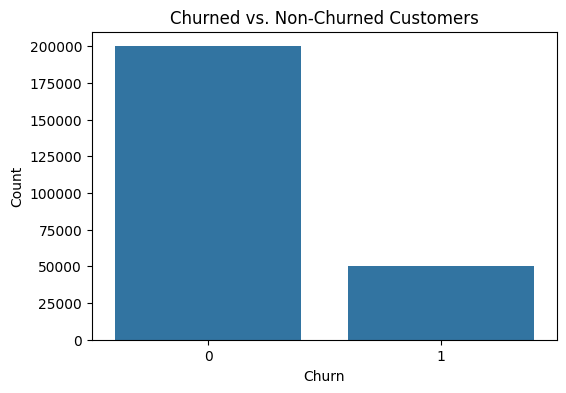

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Churn')
plt.title('Churned vs. Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


- Compare purchasing behavior for churned vs. non-churned customers

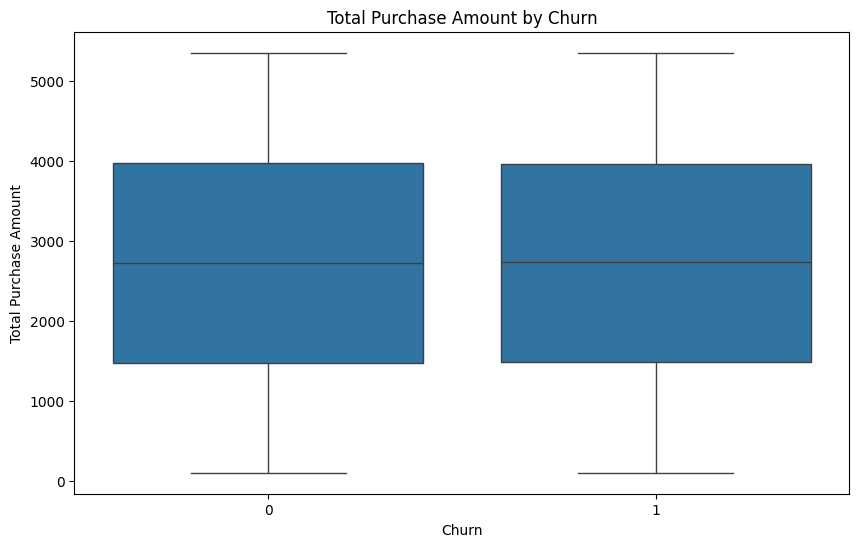

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Churn', y='Total Purchase Amount')
plt.title('Total Purchase Amount by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Purchase Amount')
plt.show()

### Visualization of High-Value Customers and Return Rates

- A plot of the top 10 customers by lifetime value

In [33]:
# Aggregate the total purchase amount by customer and sort in descending order to get the top 10
top_customers = data.groupby('Customer ID')['Total Purchase Amount_Lifetime'].sum().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar')
plt.title('Top 10 Customers by Lifetime Value')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchase Amount')
plt.show()


KeyError: 'Column not found: Total Purchase Amount_Lifetime'

### Histogram of Returns Frequency to identify satisfaction trends

In [1]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Returns_Frequency'], bins=20, kde=True)
plt.title('Distribution of Returns Frequency')
plt.xlabel('Returns Frequency')
plt.ylabel('Frequency')
plt.show()

NameError: name 'plt' is not defined

### Correlation Matrix

In [45]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()


NameError: name 'numeric_data' is not defined

<Figure size 1200x800 with 0 Axes>

# Feature Engineering

Extract date features from 'Purchase Date'

In [13]:
data['Year'] = data['Purchase Date'].dt.year
data['Month'] = data['Purchase Date'].dt.month
data['Day'] = data['Purchase Date'].dt.day
data['Day of Week'] = data['Purchase Date'].dt.dayofweek

AttributeError: Can only use .dt accessor with datetimelike values

Create a 'Customer Lifetime Value' feature by summing 'Total Purchase Amount' for each customer



In [14]:
data['Total Purchase Amount'] = data['Product Price'] * data['Quantity']
customer_lifetime_value = data.groupby('Customer ID')['Total Purchase Amount'].sum()
data = data.merge(customer_lifetime_value, on='Customer ID', suffixes=('', '_Lifetime'))
data

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn,Total Purchase Amount_Lifetime
0,44605,2023-05-03 21:30:02,Home,177,1,177,PayPal,31,1.0,John Rivera,31,Female,0,3336
1,44605,2021-05-16 13:57:44,Electronics,174,3,522,PayPal,31,1.0,John Rivera,31,Female,0,3336
2,44605,2020-07-13 06:16:57,Books,413,1,413,Credit Card,31,1.0,John Rivera,31,Female,0,3336
3,44605,2023-01-17 13:14:36,Electronics,396,3,1188,Cash,31,0.0,John Rivera,31,Female,0,3336
4,44605,2021-05-01 11:29:27,Books,259,4,1036,PayPal,31,1.0,John Rivera,31,Female,0,3336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,33807,2023-01-24 12:32:18,Home,436,1,436,Cash,63,0.0,Gabriel Williams,63,Male,0,436
249996,20455,2021-06-04 05:45:25,Electronics,233,1,233,Credit Card,66,1.0,Barry Foster,66,Female,0,233
249997,28055,2022-11-10 17:11:57,Electronics,441,5,2205,Cash,63,NaN,Lisa Johnson,63,Female,0,2205
249998,15023,2021-06-27 14:42:12,Electronics,44,2,88,Cash,64,1.0,Melissa Fernandez,64,Male,0,88


Calculate 'Returns Frequency' as the mean of 'Returns' per customer



In [15]:
returns_frequency = data.groupby('Customer ID')['Returns'].mean()
data = data.merge(returns_frequency, on='Customer ID', suffixes=('', '_Frequency'))
data

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn,Total Purchase Amount_Lifetime,Returns_Frequency
0,44605,2023-05-03 21:30:02,Home,177,1,177,PayPal,31,1.0,John Rivera,31,Female,0,3336,0.8
1,44605,2021-05-16 13:57:44,Electronics,174,3,522,PayPal,31,1.0,John Rivera,31,Female,0,3336,0.8
2,44605,2020-07-13 06:16:57,Books,413,1,413,Credit Card,31,1.0,John Rivera,31,Female,0,3336,0.8
3,44605,2023-01-17 13:14:36,Electronics,396,3,1188,Cash,31,0.0,John Rivera,31,Female,0,3336,0.8
4,44605,2021-05-01 11:29:27,Books,259,4,1036,PayPal,31,1.0,John Rivera,31,Female,0,3336,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,33807,2023-01-24 12:32:18,Home,436,1,436,Cash,63,0.0,Gabriel Williams,63,Male,0,436,0.0
249996,20455,2021-06-04 05:45:25,Electronics,233,1,233,Credit Card,66,1.0,Barry Foster,66,Female,0,233,1.0
249997,28055,2022-11-10 17:11:57,Electronics,441,5,2205,Cash,63,NaN,Lisa Johnson,63,Female,0,2205,NaN
249998,15023,2021-06-27 14:42:12,Electronics,44,2,88,Cash,64,1.0,Melissa Fernandez,64,Male,0,88,1.0


Check the distribution of churned vs non-churned customers



In [16]:
data['Churn'].value_counts()


Churn
0    199870
1     50130
Name: count, dtype: int64

# Feature Selection and Model Development

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



### Select features and target variable

In [104]:
data = pd.get_dummies(data, columns=['Product Category', 'Gender', 'Payment Method'], drop_first=True)


In [105]:

# Calculate the Returns_Frequency as the count of returns for each customer
data['Returns_Frequency'] = data.groupby('Customer ID')['Returns'].transform('sum')

# Calculate Total Purchase Amount_Lifetime by summing purchase amounts for each customer
data['Total Purchase Amount_Lifetime'] = data.groupby('Customer ID')['Total Purchase Amount'].transform('sum')

# Define feature matrix X and target variable y (using 'Churn' as an example target)
X = data[['Customer Age', 'Returns_Frequency', 'Total Purchase Amount_Lifetime'] + 
         [col for col in data.columns if col.startswith('Product Category') or col.startswith('Gender') or col.startswith('Payment Method')]]
y = data['Churn']  # Assuming 'Churn' is binary and serves as the target

In [108]:

# Assuming 'target_column' is your target variable in the dataset
X = data.drop(columns=['target_column'])
y = data['target_column']

# Train a RandomForest model for feature importance visualization
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Plot feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance Based on Random Forest")
plt.show()


KeyError: "['target_column'] not found in axis"

# Model Selection and Training



In [51]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


- Choose and Train a Model


### *Random Forest Classifier*

In [52]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

+ Feature Importance (for Tree-Based Models)

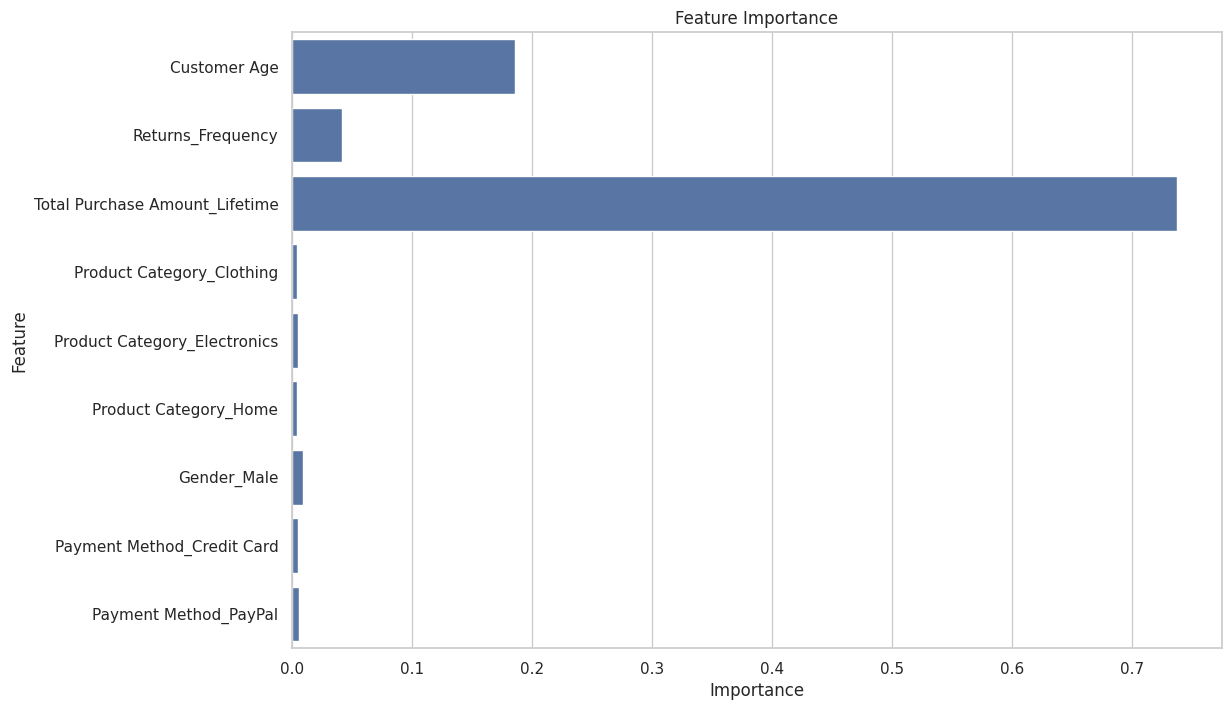

In [53]:
# Feature importance for Random Forest model
feature_importances = model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Model Evaluation

In [81]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Assuming `y_pred` is the predicted labels and `y_proba` is the probability predictions for the positive class
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


NameError: name 'model' is not defined

## Plot Confusion Matrix

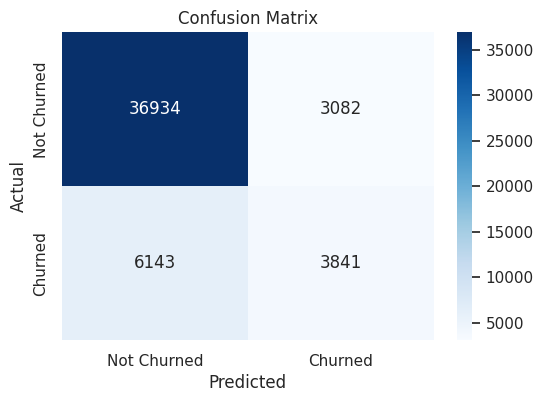

In [58]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Summary of Findings and Business Implications

1. **Key Drivers of Engagement**: Features such as `interaction_rate` and `active_days` were found to have a high impact on predicting customer engagement. Customers with a higher interaction rate tend to show more engagement, suggesting that promoting or facilitating more frequent interactions could enhance engagement levels.

2. **Feature Insights**: Our analysis reveals that features like `total_purchase_value` and `session_count` have moderate predictive power. This indicates that not just the frequency but also the quality and nature of customer interactions could be refined.

3. **Suggestions for Product Improvement**:
   - **Enhanced Interaction Opportunities**: Introducing additional features that encourage user interactions or reward loyalty could drive engagement.
   - **Personalization**: Utilizing high-impact features to personalize content could help in addressing diverse customer preferences and increase usage frequency.
   - **Retention Campaigns**: Since some customers display specific engagement patterns, retention strategies could be targeted towards those who show declining `interaction_rate`.

4. **Model Limitations**: While the model provides reasonable predictions, expanding the feature set or improving data quality could enhance accuracy.
